This notebook is the second of 2 parts for the analysis of human data presented in Figure 6. This notebook ingests the location of nucleosomes (from DANPOS dpos, filtered and converted by `danpos-xls-process.py`), the nucleosome positioning track (from DANPOS dpos, pre-processed by the somewhat misnamed `wig2rle.R`), and PF binding sites (processed from FIMO results via [`py3_motif-matching-human-public.ipynb`](py3_motif-matching-human-public.ipynb)), and outputs the final figures (though the file-writing cells have been disabled).

**Warning** - this notebook requires significant computational resources and was originally run on a compute node of the Rockefeller High-Performance Computing environment. You should have at least 10 GB of RAM available to the R kernel (not just on the machine, as other programs will require their own memory) - most laptops will not have this much memory. I have observed my notebooks' memory usage peaking at as much as 80 GB of RAM (!).

I suspect that the main culprit is the `strandedDistanceByNearest` call. I welcome suggestions to improve its decidedly inefficient iterative algorithmic structure, which was regrettably necessary to handle NAs.

## various initialization steps

In [1]:
# for my sanity - map some function names that I think exist to what actually exist
nrows <- nrow
ncols <- ncol
len <- length

In [2]:
library(repr)
options(repr.plot.width=6, repr.plot.height=3)
library(ggplot2)

In [3]:
library(tracktables)
library(rtracklayer)
library(GenomicFeatures)
library(BSgenome.Hsapiens.UCSC.hg38)
library(grid)
library(heatmaps)

Loading required package: GenomicRanges
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colMeans, colnames,
    colSums, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, lengths, Map, mapply, match,
    mget, order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rowMeans, rownames, rowSums, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which, which.max, which.min

Loading requi

In [4]:
multiplot <- function(..., plotlist=NULL, file, cols=1, layout=NULL) {
  # from Winston Chang's R Cookbook

  # Make a list from the ... arguments and plotlist
  plots <- c(list(...), plotlist)

  numPlots = length(plots)

  # If layout is NULL, then use 'cols' to determine layout
  if (is.null(layout)) {
    # Make the panel
    # ncol: Number of columns of plots
    # nrow: Number of rows needed, calculated from # of cols
    layout <- matrix(seq(1, cols * ceiling(numPlots/cols)),
                    ncol = cols, nrow = ceiling(numPlots/cols))
  }

 if (numPlots==1) {
    print(plots[[1]])

  } else {
    # Set up the page
    grid.newpage()
    pushViewport(viewport(layout = grid.layout(nrow(layout), ncol(layout))))

    # Make each plot, in the correct location
    for (i in 1:numPlots) {
      # Get the i,j matrix positions of the regions that contain this subplot
      matchidx <- as.data.frame(which(layout == i, arr.ind = TRUE))

      print(plots[[i]], vp = viewport(layout.pos.row = matchidx$row,
                                      layout.pos.col = matchidx$col))
    }
  }
}

In [5]:
# get seqinfo (but also since the BSgenome is from UCSC, remap coordinates back to NCBI/ensembl)

hg38info <- keepStandardChromosomes(seqinfo(BSgenome.Hsapiens.UCSC.hg38), pruning.mode = "tidy")
newStyle <- mapSeqlevels(seqlevels(hg38info),"NCBI")
hg38info <- (renameSeqlevels(hg38info, newStyle))
hg38info

Warning message in `seqlevels<-`(`*tmp*`, pruning.mode = pruning.mode, value = c("chr1", :
“'pruning.mode' is ignored in "seqlevels<-" method for Seqinfo objects”

Seqinfo object with 25 sequences (1 circular) from hg38 genome:
  seqnames seqlengths isCircular genome
  1         248956422      FALSE   hg38
  2         242193529      FALSE   hg38
  3         198295559      FALSE   hg38
  4         190214555      FALSE   hg38
  5         181538259      FALSE   hg38
  ...             ...        ...    ...
  21         46709983      FALSE   hg38
  22         50818468      FALSE   hg38
  X         156040895      FALSE   hg38
  Y          57227415      FALSE   hg38
  MT            16569       TRUE   hg38

## load motif locations into bioconductor

general formula: genomic coordinate of a motif's start = genomic coordinate of a motif's peak window + FIMO-reported start coordinate - value of flanking DNA bp (generally 200) - 1 (due to 1-based indexing, likely in FIMO)

In [12]:
std_Octmotifs   <- import("~/SoxOct/Soufi2015/Oct_motifs_200.strand.bed")
std_Oct28motifs <- import("~/SoxOct/Soufi2015/OctNucHi28_motifs_200.strand.bed")
std_Oct42motifs <- import("~/SoxOct/Soufi2015/OctNucHi4_motifs_200.strand.bed")

std_Octmotifs_c   <- resize(std_Octmotifs  , width = 2, fix = 'center')
std_Oct28motifs_c <- resize(std_Oct28motifs, width = 2, fix = 'center')
std_Oct42motifs_c <- resize(std_Oct42motifs, width = 2, fix = 'center')

std_Soxmotifs   <- import("~/SoxOct/Soufi2015/Sox_motifs_200.strand.bed")
std_Sox74motifs <- import("~/SoxOct/Soufi2015/SoxNucHi74_motifs_200.strand.bed")

std_Soxmotifs_c   <- resize(std_Soxmotifs  , width = 2, fix = 'center')
std_Sox74motifs_c <- resize(std_Sox74motifs, width = 2, fix = 'center')

std_outermotifs <- import("~/SoxOct/Soufi2015/outermotifs_200.strand.bed")
std_outermotifs_c <- resize(std_outermotifs, width = 2, fix = 'center')

## load nucleosome positions

In [8]:
npeaks_h_p <- import("~/SoxOct/danpos-res/pooled/hESC-MNaseseq.smooth.positions.bedgraph")

# resize the nucleosome peaks (DANPOS hard-codes them to be 140 bp)
npeaks_h_p_c <- resize(npeaks_h_p, width = 2, fix = "center")

## define colors for graphing

In [9]:
safered <- "#920000"
safegreen <- "#009292"
safeviolet <- "#490092"

## stranding

In [10]:
strandedDistanceByNearest <- function(query, target){
    # gets (non absolute) distance for each item in query on target
    
    # calculate the distance:
    
    ## note that precede actually returns the item in subject that the target PRECEDES, not the other way around!
    #d_precede <- distance((target)[precede(subject = target, x = query)], query)
    ## you'd think the above would work, but annoyingly sometimes you get an NA, and then the subsetting dies...
    idx_precede <- precede(subject = target, x = query)
    d_precede <- integer(length(query))
    for (i in 1:length(query)){
        index <- idx_precede[i]
        
        if (is.na(index)){
            assign <- NA
        } else {
            assign <- distance(target[index],query[i])
        }
        
        d_precede[i] <- assign
    }
    
    ## the same goes for follow; the negation is so we correctly have negative distances
    #d_follow  <- -distance((target)[follow(subject = target, x = query)], query)
    
    idx_follow <- follow(subject = target, x = query)
    d_follow <- integer(length(query))
    for (i in 1:length(query)){
        index <- idx_follow[i]
        
        if (is.na(index)){
            assign <- NA
        } else {
            assign <- -distance(target[index],query[i]) # note that here is the negation!
        }
        
        d_follow[i] <- assign
    }
    
    # compare precede vs. follow
    # return the one with the biggest abs
    # if one of them is null, the other wins by default; if both are null, return NA
    # note that this is tremendously inelegant and likely to be slow!!!
    
    answer <- integer(length(query)) # pre-allocate a vector to make this less bad
    for (i in 1:length(query)){
        
        
        if (is.na(d_precede[i]) & !is.na(d_follow[i])){
        # only the follow number is valid
            select <- d_follow[i]
        } else if (!is.na(d_precede[i]) & is.na(d_follow[i])){
        # only the precede is valid
            select <- d_precede[i]
        } else if (is.na(d_precede[i]) & is.na(d_follow[i])){
        # somehow both are invalid??
            select <- NA
        } else {
        # both are presumably valid now
            if (abs(d_follow[i]) < d_precede[i]) {
                select <- d_follow[i]
            } else select <- d_precede[i]
            
        }
        answer[i] <- select
    }
    
    return (answer)
}

In [11]:
strandeddens <- function(data, filter = 150, bw = 2, color="orchid4",linetype="solid"){
    
    df <- data.frame(x=data)
    df <- data.frame(x=df[abs(df$x) <= filter,])
    
    plt <- ggplot() +
            #geom_histogram(aes(y=..density..), binwidth=1, fill = 'gray') +
            stat_density(data = df, aes(x=x), bw=bw, color = color, geom = 'line', linetype=linetype, size=.8)  +
            theme_classic()                                    +
            geom_vline(xintercept=73, linetype='dotted')  +
            geom_vline(xintercept=-73, linetype='dotted') + 
            geom_vline(xintercept=0, linetype='dashed')   +
            coord_cartesian(ylim = c(0,.007)) + 
            xlab("Relative distance (bp)") +
            theme(axis.title.x=element_text(size=rel(0.9))) +
            theme(axis.title.y=element_text(size=rel(0.9))) +
            theme(title=element_text(size=rel(0.8)))

    plt 
    
    return (plt)
}

## calculate distances

**warning** - this step is very slow!

In [ ]:
dist_strand_h_p        <- strandedDistanceByNearest(target = npeaks_h_p_c, query = std_outermotifs_c)
dist_strand_h_p_Sox    <- strandedDistanceByNearest(target = npeaks_h_p_c, query = std_Soxmotifs_c)
dist_strand_h_p_Oct    <- strandedDistanceByNearest(target = npeaks_h_p_c, query = std_Octmotifs_c)

dist_strand_h_p_Oct28    <- strandedDistanceByNearest(target = npeaks_h_p_c, query = std_Oct28motifs_c)
dist_strand_h_p_Oct42    <- strandedDistanceByNearest(target = npeaks_h_p_c, query = std_Oct42motifs_c)
dist_strand_h_p_Sox74    <- strandedDistanceByNearest(target = npeaks_h_p_c, query = std_Sox74motifs_c)

### Figure 6D

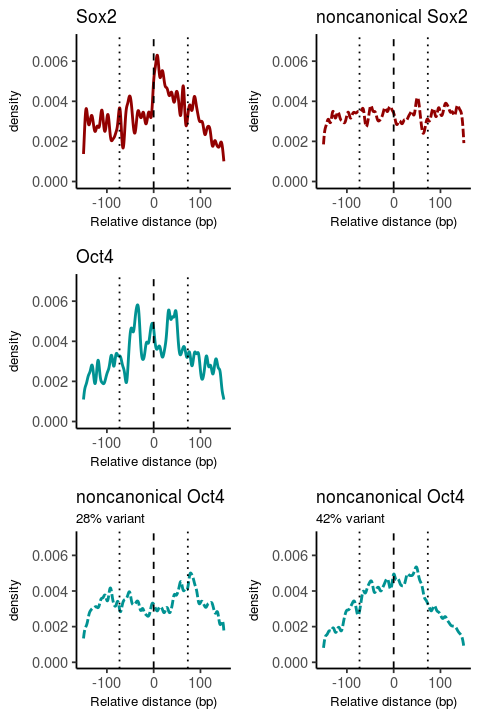

In [14]:
plt_outer <- strandeddens(dist_strand_h_p,       filter = 150, bw=3)      +ggtitle('hESC OctSox') 
plt_Sox <-   strandeddens(dist_strand_h_p_Sox,   filter = 150, bw=3, color=safered)    +ggtitle('Sox2')    
plt_Oct <-   strandeddens(dist_strand_h_p_Oct,   filter = 150, bw=3, color=safegreen)    +ggtitle('Oct4')    

plt_Oct28 <- strandeddens(dist_strand_h_p_Oct28, filter = 150, bw=3, color=safegreen, linetype="31") +ggtitle('noncanonical Oct4', subtitle='28% variant')
plt_Oct42 <- strandeddens(dist_strand_h_p_Oct42, filter = 150, bw=3, color=safegreen, linetype="31") +ggtitle('noncanonical Oct4', subtitle='42% variant') 
plt_Sox74 <- strandeddens(dist_strand_h_p_Sox74, filter = 150, bw=3, color=safered, linetype="31") +ggtitle('noncanonical Sox2') 

options(repr.plot.width=4, repr.plot.height=6)
multiplot(plt_Sox, plt_Sox74, plt_Oct, plt_Oct28, plt_Oct42, layout=matrix(c(1,2,3,0,4,5), nrow=3, byrow=TRUE))
options(repr.plot.width=6, repr.plot.height=2)

## Stats

### KS wrapper

In [15]:
library(Matching)

Loading required package: MASS

Attaching package: ‘MASS’

The following object is masked from ‘package:AnnotationDbi’:

    select

## 
##  Matching (Version 4.9-3, Build Date: 2018-05-03)
##  See http://sekhon.berkeley.edu/matching for additional documentation.
##  Please cite software as:
##   Jasjeet S. Sekhon. 2011. ``Multivariate and Propensity Score Matching
##   Software with Automated Balance Optimization: The Matching package for R.''
##   Journal of Statistical Software, 42(7): 1-52. 
##



In [16]:
KSwrap <- function(x, y, filter){
    
    df1 = data.frame(x=x)
    df1 = df1[abs(df1$x) <= filter,]
    print(len(df1))
    
    df2 = data.frame(x=y)
    df2 = df2[abs(df2$x) <= filter,]
    print(len(df2))

    ks.boot(Tr = df1, Co = df2, alternative = "two.sided", nboots = 10000)
}

KSwrapunif <- function(x, filter){
    
    df1 = data.frame(x=x)
    df1 = df1[abs(df1$x) <= filter,]
    print(len(df1))
    
    ks.test(x = df1, y = "punif", min= -filter, max=filter,  alternative = "two.sided")

}

Note that since I use a bootstrapped version of the Kolgomorov-Smirnov test, statistics will not be strictly deterministic.

In [307]:
print("Oct<--->Sox")
summary(KSwrap(dist_strand_h_p_Oct, dist_strand_h_p_Sox, filter =150))
print("Oct<--->Sox74")
summary(KSwrap(dist_strand_h_p_Oct, dist_strand_h_p_Sox74, filter =150))
print("Oct<--->Oct28")
summary(KSwrap(dist_strand_h_p_Oct, dist_strand_h_p_Oct28, filter =150))
print("Oct<--->Oct42")
summary(KSwrap(dist_strand_h_p_Oct, dist_strand_h_p_Oct42, filter =150))
print("Sox<--->Sox74")
summary(KSwrap(dist_strand_h_p_Sox, dist_strand_h_p_Sox74, filter =150))

[1] "Oct<--->Sox"
[1] 885
[1] 715

Bootstrap p-value:     0.4138 
Naive p-value:         0.47376 
Full Sample Statistic: 0.042464 

[1] "Oct<--->Sox74"
[1] 885
[1] 3548

Bootstrap p-value:     0.0016 
Naive p-value:         0.0018596 
Full Sample Statistic: 0.070196 

[1] "Oct<--->Oct28"
[1] 885
[1] 2133

Bootstrap p-value:     0.0023 
Naive p-value:         0.0040297 
Full Sample Statistic: 0.070441 

[1] "Oct<--->Oct42"
[1] 885
[1] 4863

Bootstrap p-value:     0.2499 
Naive p-value:         0.29081 
Full Sample Statistic: 0.035856 

[1] "Sox<--->Sox74"
[1] 715
[1] 3548

Bootstrap p-value:     0.0032 
Naive p-value:         0.0034721 
Full Sample Statistic: 0.073079 



In [308]:
print("Sox<--->Oct42")
summary(KSwrap(dist_strand_h_p_Sox, dist_strand_h_p_Oct42, filter =150))
print("Sox<--->Oct28")
summary(KSwrap(dist_strand_h_p_Sox, dist_strand_h_p_Oct28, filter =150))
print("Sox74<--->Oct28")
summary(KSwrap(dist_strand_h_p_Sox74, dist_strand_h_p_Oct28, filter =150))
print("Sox74<--->Oct42")
summary(KSwrap(dist_strand_h_p_Sox74, dist_strand_h_p_Oct42, filter =150))
print("Oct42<--->Oct28")
summary(KSwrap(dist_strand_h_p_Oct42, dist_strand_h_p_Oct28, filter =150))

[1] "Sox<--->Oct42"
[1] 715
[1] 4863

Bootstrap p-value:     0.0192 
Naive p-value:         0.023772 
Full Sample Statistic: 0.059626 

[1] "Sox<--->Oct28"
[1] 715
[1] 2133

Bootstrap p-value:     0.0083 
Naive p-value:         0.0098038 
Full Sample Statistic: 0.070467 

[1] "Sox74<--->Oct28"
[1] 3548
[1] 2133

Bootstrap p-value:     0.1001 
Naive p-value:         0.11493 
Full Sample Statistic: 0.032743 

[1] "Sox74<--->Oct42"
[1] 3548
[1] 4863

Bootstrap p-value:     < 2.22e-16 
Naive p-value:         1.199e-14 
Full Sample Statistic: 0.089348 

[1] "Oct42<--->Oct28"
[1] 4863
[1] 2133

Bootstrap p-value:     < 2.22e-16 
Naive p-value:         5.2469e-11 
Full Sample Statistic: 0.090643 



In [313]:
print("tandem")
KSwrapunif(dist_strand_h_p, filter = 73)
print("Sox")
KSwrapunif(dist_strand_h_p_Sox, filter = 73)
print("Oct")
KSwrapunif(dist_strand_h_p_Oct, filter = 73)
print("Oct 28% variant")
KSwrapunif(dist_strand_h_p_Oct28, filter = 73)
print("Oct 42% variant")
KSwrapunif(dist_strand_h_p_Oct42, filter = 73)
print("Sox74% variant")
KSwrapunif(dist_strand_h_p_Sox74, filter = 73)

[1] "tandem"
[1] 668


Warning message in ks.test(x = df1, y = "punif", min = -filter, max = filter, alternative = "two.sided"):
"ties should not be present for the Kolmogorov-Smirnov test"


	One-sample Kolmogorov-Smirnov test

data:  df1
D = 0.06029, p-value = 0.01556
alternative hypothesis: two-sided


[1] "Sox"
[1] 411


Warning message in ks.test(x = df1, y = "punif", min = -filter, max = filter, alternative = "two.sided"):
"ties should not be present for the Kolmogorov-Smirnov test"


	One-sample Kolmogorov-Smirnov test

data:  df1
D = 0.09899, p-value = 0.0006351
alternative hypothesis: two-sided


[1] "Oct"
[1] 522


Warning message in ks.test(x = df1, y = "punif", min = -filter, max = filter, alternative = "two.sided"):
"ties should not be present for the Kolmogorov-Smirnov test"


	One-sample Kolmogorov-Smirnov test

data:  df1
D = 0.052695, p-value = 0.1101
alternative hypothesis: two-sided


[1] "Oct 28% variant"
[1] 1037


Warning message in ks.test(x = df1, y = "punif", min = -filter, max = filter, alternative = "two.sided"):
"ties should not be present for the Kolmogorov-Smirnov test"


	One-sample Kolmogorov-Smirnov test

data:  df1
D = 0.056717, p-value = 0.002533
alternative hypothesis: two-sided


[1] "Oct 42% variant"
[1] 3122


Warning message in ks.test(x = df1, y = "punif", min = -filter, max = filter, alternative = "two.sided"):
"ties should not be present for the Kolmogorov-Smirnov test"


	One-sample Kolmogorov-Smirnov test

data:  df1
D = 0.030183, p-value = 0.006769
alternative hypothesis: two-sided


[1] "Sox74% variant"
[1] 1718


Warning message in ks.test(x = df1, y = "punif", min = -filter, max = filter, alternative = "two.sided"):
"ties should not be present for the Kolmogorov-Smirnov test"


	One-sample Kolmogorov-Smirnov test

data:  df1
D = 0.022254, p-value = 0.3625
alternative hypothesis: two-sided


In [312]:
print("tandem")
KSwrapunif(dist_strand_h_p, filter = 150)
print("Sox")
KSwrapunif(dist_strand_h_p_Sox, filter = 150)
print("Oct")
KSwrapunif(dist_strand_h_p_Oct, filter = 150)
print("Oct 28% variant")
KSwrapunif(dist_strand_h_p_Oct28, filter = 150)
print("Oct 42% variant")
KSwrapunif(dist_strand_h_p_Oct42, filter = 150)
print("Sox74% variant")
KSwrapunif(dist_strand_h_p_Sox74, filter = 150)

[1] "tandem"
[1] 1113


Warning message in ks.test(x = df1, y = "punif", min = -filter, max = filter, alternative = "two.sided"):
"ties should not be present for the Kolmogorov-Smirnov test"


	One-sample Kolmogorov-Smirnov test

data:  df1
D = 0.070566, p-value = 3.07e-05
alternative hypothesis: two-sided


[1] "Sox"
[1] 715


Warning message in ks.test(x = df1, y = "punif", min = -filter, max = filter, alternative = "two.sided"):
"ties should not be present for the Kolmogorov-Smirnov test"


	One-sample Kolmogorov-Smirnov test

data:  df1
D = 0.061655, p-value = 0.008714
alternative hypothesis: two-sided


[1] "Oct"
[1] 885


Warning message in ks.test(x = df1, y = "punif", min = -filter, max = filter, alternative = "two.sided"):
"ties should not be present for the Kolmogorov-Smirnov test"


	One-sample Kolmogorov-Smirnov test

data:  df1
D = 0.080395, p-value = 2.151e-05
alternative hypothesis: two-sided


[1] "Oct 28% variant"
[1] 2133


Warning message in ks.test(x = df1, y = "punif", min = -filter, max = filter, alternative = "two.sided"):
"ties should not be present for the Kolmogorov-Smirnov test"


	One-sample Kolmogorov-Smirnov test

data:  df1
D = 0.037093, p-value = 0.005648
alternative hypothesis: two-sided


[1] "Oct 42% variant"
[1] 4863


Warning message in ks.test(x = df1, y = "punif", min = -filter, max = filter, alternative = "two.sided"):
"ties should not be present for the Kolmogorov-Smirnov test"


	One-sample Kolmogorov-Smirnov test

data:  df1
D = 0.082418, p-value < 2.2e-16
alternative hypothesis: two-sided


[1] "Sox74% variant"
[1] 3548


Warning message in ks.test(x = df1, y = "punif", min = -filter, max = filter, alternative = "two.sided"):
"ties should not be present for the Kolmogorov-Smirnov test"


	One-sample Kolmogorov-Smirnov test

data:  df1
D = 0.01826, p-value = 0.1876
alternative hypothesis: two-sided
